In [7]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tablepyxl import tablepyxl
from copy import deepcopy
import numpy as np
import io
from PIL import Image
import fitz


In [8]:
from paddleocr import PPStructure,save_structure_res
from paddleocr.ppstructure.recovery.recovery_to_doc import sorted_layout_boxes, convert_info_docx

In [9]:
doc = fitz.open('Sample\IOL.pdf')
page = doc[0]
pix = page.get_pixmap(dpi=300)
byte = io.BytesIO(pix.pil_tobytes(format="JPEG"))
image_pil = Image.open(byte)
img_arr = np.asarray(image_pil)

In [10]:
# read image table
# path = 'Sample/IOL.png'
# img = cv2.imread(path)
# img = cv2.resize(img, (1000, 1500), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# img = img[600:795, 80:520]
# plt.imshow(img)

In [119]:
# read circle
# path = 'Sample/S__33579013.jpg'
# img = cv2.imread(path)
# img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# img = img[400:800 , 750:1050]
# plt.imshow(img)

In [120]:
# ocr circle
# path = 'Sample/out.png'
# img = cv2.imread(path)
# # img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# img = img[1530:1850, 800:1200]
# # plt.imshow(img)
# img = Image.fromarray(img)

In [11]:
tmp = {
    "name1": [
        {
            "id": "circle_right",
            "type": "image",
            "box_pos": [100, 2400, 1300, 3000]  # [x1, y1, x2, y2]
        },
        {
            "id": "circle_left",
            "type": "image",
            "box_pos": [1550, 1600, 1900, 1850]
        }
    ],
    "name2": [
        {
            "id": "name",
            "type": "text",
            "box_pos": [127.440, 741.671, 204.817, 749.921]
        },
        {
            "id": "id",
            "type": "text",
            "box_pos": [127.440, 721.511, 164.136, 729.761]
        },
        {
            "id": "DOB",
            "type": "text",
            "box_pos": [127.440, 708.551, 164.119, 716.801]
        }
    ]
}

data_input = [{
        "template_name": tmp['name1'],
        "image": image_pil,
        "page": 1,
}]

In [12]:
# load model
def load_model(image_orientation=True):
    """
    load model from paddleocr (PPStructure)

    Returns:
        tabular engine model
    """
    table_engine = PPStructure(recovery=True, lang='en',image_orientation=image_orientation)
    return table_engine

def predict(table_engine, image):
    """
    predict table from image

    Args:
        table_engine: tabular engine model
        image: input image

    Returns:
        result of prediction
    """
    result = table_engine(image)
    return result

def process_result(result):
    """
    process result from prediction

    Args:
        result: result of prediction

    Returns:
        dataframe from result
    """
    result_cp = deepcopy(result)
    df_ls = []
    for region in result_cp:
        # if region is table
        if 'html' in region['res']:
            html = region['res']['html']
            wb = tablepyxl.document_to_workbook(html)
            output = io.BytesIO()
            wb.save(output)
            output.seek(0)
            df = pd.read_excel(output, header=None)
            df_ls.append(df)
        # else region is circle
        else:
            text_ls = []
            for text in region['res']:
                text_ls.append(text['text'])
            df = pd.DataFrame(text_ls)
            df_ls.append(df)
    if len(df_ls) == 0:
        return pd.DataFrame()
    else:    
        return pd.concat(df_ls, axis=0) 

def inference(data_input, engine):
    """
    inference from input data

    Args:
        data_input (dict): input data
        engine : engine model

    Returns:
        dataframe from result    
    """
    df_predict_ls = []
    for page_index in range(len(data_input)):
        page = data_input[page_index]
        # image_path = page['path']
        # image = cv2.imread(image_path)
        image = page['image']
        image = np.asarray(image)
        for box_index in range(len(page['template_name'])):
            x1, y1, x2, y2 = page['template_name'][box_index]['box_pos']
            roi_image = image[y1:y2, x1:x2]
            result = predict(engine, roi_image)
            df_predict = process_result(result)
            columns_ls = [page['template_name'][box_index]['id']] * (len(df_predict.columns))
            df_predict.columns = columns_ls
            df_predict_ls.append(df_predict)
            
    return pd.concat(df_predict_ls, axis=1)
    # return df_predict_ls


In [134]:
table_engine = load_model()

[2023/12/13 01:51:53] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir=None, cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\earth/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_vali

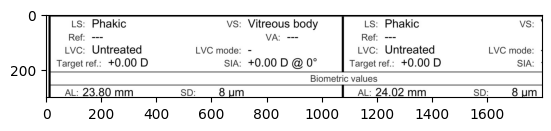

In [158]:
roi_image = img_arr[1200:1500,200:2000]
plt.imshow(roi_image)

In [159]:
table_engine = PPStructure(recovery=True, lang='en', image_orientation=True)

[2023/12/13 02:37:44] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir=None, cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\earth/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_vali

In [160]:
save_folder = "output"
img_path = "test2"

In [161]:
result = table_engine(roi_image)
save_structure_res(result, save_folder,os.path.basename(img_path).split('.')[0])

[2023/12/13 02:37:50] ppocr DEBUG: dt_boxes num : 22, elapse : 0.15230655670166016
[2023/12/13 02:37:53] ppocr DEBUG: rec_res num  : 22, elapse : 2.910076141357422
[2023/12/13 02:37:53] ppocr DEBUG: dt_boxes num : 22, elapsed : 0.15043067932128906
[2023/12/13 02:37:57] ppocr DEBUG: rec_res num  : 22, elapsed : 3.1911370754241943


In [170]:
result[0]['res']['cell_bbox']

[[116.1758804321289, 14.295053482055664, 289.90399169921875, 80.5298843383789],
 [653.1324462890625, 17.216310501098633, 766.1653442382812, 70.56110382080078],
 [711.1451416015625, 15.82458209991455, 1002.513916015625, 79.63614654541016],
 [1128.00732421875, 15.616422653198242, 1293.0472412109375, 93.01714324951172],
 [1535.19775390625, 18.528779983520508, 1678.9246826171875, 81.89425659179688],
 [1680.0833740234375, 20.93311309814453, 1753.713623046875, 71.61421203613281],
 [52.526031494140625,
  79.13577270507812,
  355.21527099609375,
  150.75228881835938],
 [666.8547973632812, 96.36714172363281, 960.2879638671875, 157.15504455566406],
 [724.2755737304688, 93.7721939086914, 852.9892578125, 159.30372619628906],
 [931.0572509765625,
  85.89129638671875,
  1118.9366455078125,
  162.80789184570312],
 [1186.9908447265625, 85.6989974975586, 1421.47412109375, 169.00946044921875],
 [1592.476806640625,
  103.19001007080078,
  1774.0286865234375,
  168.0091552734375],
 [59.36061096191406, 127

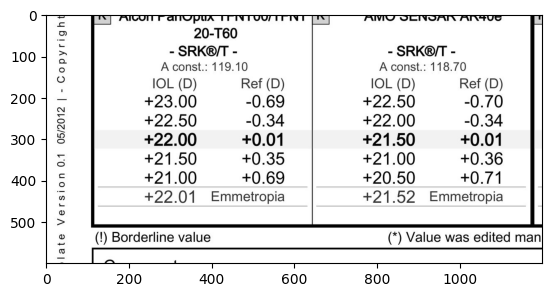

[2023/12/13 02:29:32] ppocr DEBUG: dt_boxes num : 37, elapse : 0.4668874740600586
[2023/12/13 02:29:39] ppocr DEBUG: rec_res num  : 37, elapse : 6.067033767700195
            circle_right                     circle_right
0   nPanoptx TFNTooATFNT                              NaN
1      20-T60 - SRKO/T -                  AMOSENSAR AR40e
2        A const.:119.10                       - SRKO/T -
3        IOL (D) Ref (D)  A const.:118.70 IOL (D) Ref (D)
4           +23.00 -0.69                     +22.50 -0.70
5           +22.50 -0.34                     +22.00 -0.34
6           +22.00 +0.01                     +21.50 +0.01
7           +21.50 +0.35                     +21.00 +0.36
8           +21.00 +0.69                     +20.50 +0.71
9      +22.01 Emmetropia                +21.52 Emmetropia
10   () Borderline value          (*)Value was edited mar


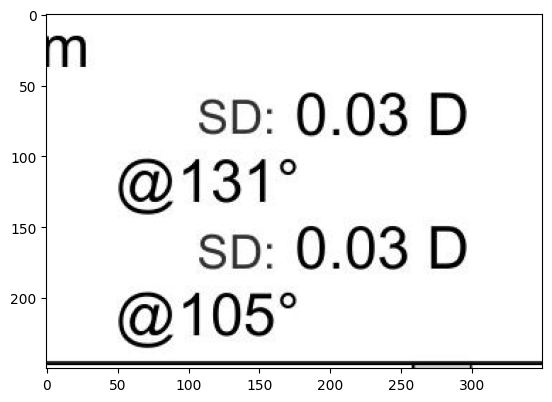

[2023/12/13 02:29:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.0855245590209961
[2023/12/13 02:29:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.5085289478302002
  circle_left
0     SD0.03D
1        @131
2     SD0.03D
3        @105


In [14]:
engine = table_engine
df_predict_ls = []

for page_index in range(len(data_input)):
    page = data_input[page_index]
    image = page['image']
    image = np.asarray(image)
    for box_index in range(len(page['template_name'])):
        x1, y1, x2, y2 = page['template_name'][box_index]['box_pos']
        roi_image = image[y1:y2, x1:x2]
        plt.imshow(roi_image)
        plt.show()
        result = predict(engine, roi_image)
        df_predict = process_result(result)
        columns_ls = [page['template_name'][box_index]['id']] * (len(df_predict.columns))
        df_predict.columns = columns_ls
        df_predict_ls.append(df_predict)
        print(df_predict)
        

In [124]:
inference(data_input, table_engine)

[2023/12/13 01:42:10] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12517857551574707
[2023/12/13 01:42:11] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7826662063598633
[2023/12/13 01:42:12] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.11687660217285156
[2023/12/13 01:42:13] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7752714157104492


,circle_right,circle_left
0,89,108
1,86,101
2,88,87
3,65,75
4,81,62
5,71,58
